In [2]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split

import sys




In [3]:
# open hdf5
path = "../DATA/contribution_22_full.hdf5"
ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 329MB
Dimensions:                 (wavelength: 52, sample: 91392, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 731kB 0 1 2 3 ... 91389 91390 91391
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 38MB ...
    noise                   (sample, wavelength) float64 38MB ...
    planet_temp_k           (sample) float64 731kB ...
    log_H2O                 (sample) float64 731kB ...
    log_CO2                 (sample) float64 731kB ...
    ...                      ...
    planet_radius_m         (sample) float64 731kB ...
    planet_surface_gravity  (sample) float64 731kB ...
    valid_quartiles         (sample) bool 91kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 13MB ...
    contributions           (sample, species, wavelength) float64 190MB ...
    clean_forward_model     (sample, wavelength) float64 38MB ...

In [4]:
ipath = "train_validation_indecies.hdf5"
ids = xr.open_dataset(ipath)
ids

<xarray.Dataset> Size: 731kB
Dimensions:    (train_samples: 73113, val_samples: 18279)
Dimensions without coordinates: train_samples, val_samples
Data variables:
    train_idx  (train_samples) int64 585kB ...
    val_idx    (val_samples) int64 146kB ...

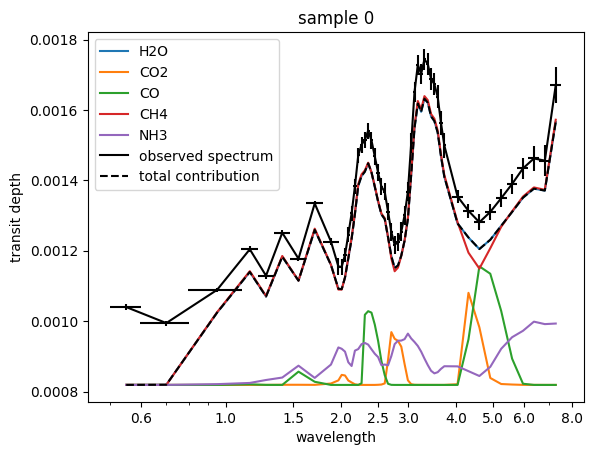

In [5]:
i = 0
all_species = ds.species.values[1:]

plt.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2', 'CO', 'CH4', 'NH3']
                    ).values.T, label=['H2O', 'CO2', 'CO', 'CH4', 'NH3'])

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()

In [6]:
label_names = ['log_H2O', 'log_CO2']
labels = ds[label_names]
labels_np = labels.to_array().values.T

labels_np.shape

(91392, 2)

In [7]:
spectrum_np = ds['spectrum'].values
spectrum_np.shape

(91392, 52)

In [8]:
noise_np = ds['noise'].values
noise_np.shape

(91392, 52)

In [9]:
train_spectra = spectrum_np[ids['train_idx']]
train_labels = labels_np[ids['train_idx']]
train_noise = noise_np[ids['train_idx']]
train_spectra.shape, train_labels.shape, train_noise.shape

((73113, 52), (73113, 2), (73113, 52))

In [10]:
# split train into train and test
train_spectra, test_spectra, train_labels, test_labels, train_noise, test_noise = train_test_split(train_spectra, train_labels, train_noise, test_size=0.2, random_state=42)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}
train_noise: {train_noise.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
test_noise: {test_noise.shape}
""")


train_spectra: (58490, 52)
train_labels: (58490, 2)
train_noise: (58490, 52)

test_spectra: (14623, 52)
test_labels: (14623, 2)
test_noise: (14623, 52)



In [11]:
class normaliser():
    def __init__(self):
        self.mean = None
        self.std = None
    
        
    def normalise(self, data, set=False):
        if set:
            self.mean = np.mean(data, axis=0)
            self.std = np.std(data, axis=0)

        return (data - self.mean) / self.std
    
    def denormalise(self, data):  
        return data * self.std + self.mean
        


In [12]:
labels_normaliser = normaliser()
spectra_normaliser = normaliser()

train_labels_normalised = labels_normaliser.normalise(train_labels, set=True)
train_spectra_normalised = spectra_normaliser.normalise(train_spectra, set=True)

test_labels_normalised = labels_normaliser.normalise(test_labels)
test_spectra_normalised = spectra_normaliser.normalise(test_spectra)


In [13]:
# create a model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [14]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()

        self.fc1 = nn.Linear(52, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [15]:
model = NetA()

# create a loss function
criterion = nn.MSELoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #lr=0.0005)

# create a data loader
batch_size = 128
train_dataset = TensorDataset(torch.Tensor(train_spectra_normalised), torch.Tensor(train_labels_normalised))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# load the best model 
model.load_state_dict(torch.load('modela.pt'))

<All keys matched successfully>

In [17]:
# make predictions
model.eval()

with torch.no_grad():
    predictions = model(torch.Tensor(test_spectra_normalised))

predictions = labels_normaliser.denormalise(predictions.numpy())

print(f'len(predictions): {predictions.shape}')
print(f'len(test_labels): {test_labels.shape}')

len(predictions): (14623, 2)
len(test_labels): (14623, 2)


## information theory

In [23]:
# Assume test_spectra and observation_uncertainty are already defined with shapes (n_samples, 52)
n_samples, n_wavelengths = test_spectra.shape  # n_wavelengths should be 52
n_replicates = 100

# Preallocate the output array with shape:
# (n_samples, 52 (spectrum features), 100 (replicates))
augmented_spectra = np.empty((n_samples, n_wavelengths, n_replicates))

# Reshape test_spectra for broadcasting to (n_samples, 52, 100)
base_spectra_expanded = np.expand_dims(test_spectra, axis=(2))
base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_replicates))

# Generate noise for all perturbations and replicates simultaneously
noise = np.random.normal(
    loc=0.0,
    scale=np.expand_dims(test_noise, axis=(2)),
    size=(n_samples, n_wavelengths, n_replicates)
)

augmented_spectra = base_spectra_expanded + noise 

print("Noisy spectra generated with shape:", augmented_spectra.shape)

Noisy spectra generated with shape: (14623, 52, 100)


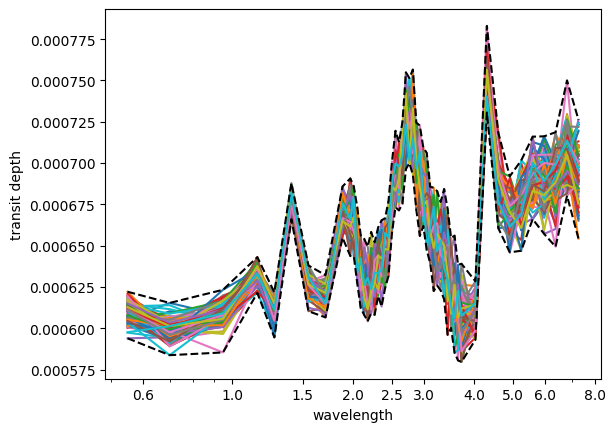

In [24]:
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :],label='mean')
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :].min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,augmented_spectra[0, :, :].max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [26]:
# normalise the spectra
aug_spectra_normaliser = normaliser()
augmented_spectra_normalised = aug_spectra_normaliser.normalise(augmented_spectra, set=True)

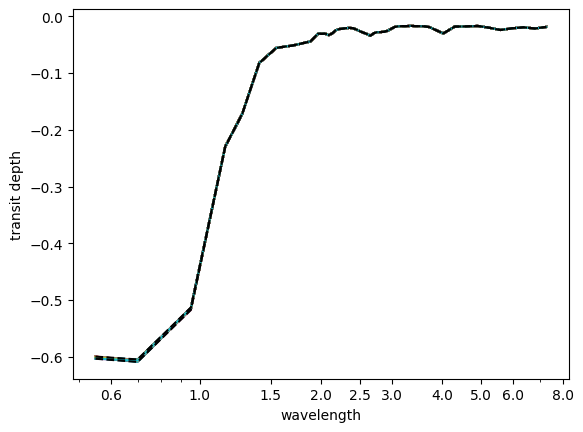

In [27]:
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[0, :, :],label='mean')
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[0, :, :].min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,augmented_spectra_normalised[0, :, :].max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

## pertubation sensitivity

In [19]:
# Assume test_spectra and observation_uncertainty are already defined with shapes (n_samples, 52)
n_samples, n_wavelengths = test_spectra.shape  # n_wavelengths should be 52
n_replicates = 5

# Preallocate the output array with shape:
# (n_samples, 52 (spectrum features), 52 (perturbed wavelength index), 100 (replicates))
noisy_spectra = np.empty((n_samples, n_wavelengths, n_wavelengths, n_replicates))

# Reshape test_spectra for broadcasting to (n_samples, 52, 52, 100)
base_spectra_expanded = np.expand_dims(test_spectra, axis=(2, 3))
base_spectra_expanded = np.tile(base_spectra_expanded, (1, 1, n_wavelengths, n_replicates))

# Generate noise for all perturbations and replicates simultaneously
noise = np.random.normal(
    loc=0.0,
    scale=np.expand_dims(test_noise, axis=(2, 3)),
    size=(n_samples, n_wavelengths, n_wavelengths, n_replicates)
)

# Add noise only to the specific wavelength index being perturbed
perturb_mask = np.eye(n_wavelengths, dtype=bool)[np.newaxis, :, :, np.newaxis]  # Shape (1, 52, 52, 1)
noisy_spectra = base_spectra_expanded + (noise * perturb_mask)

print("Noisy spectra generated with shape:", noisy_spectra.shape)

KeyboardInterrupt: 

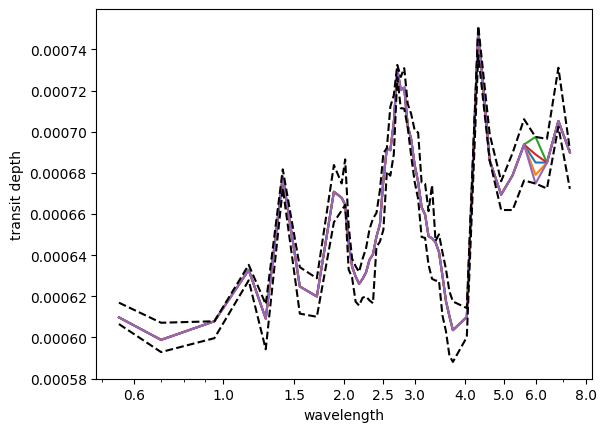

In [ ]:
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, 48])
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].min(axis=2).min(axis=1), 'k--',label='min')
plt.plot(  ds['wavelength'] ,noisy_spectra[0, :, :].max(axis=2).max(axis=1), "k--",label='max')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()

In [ ]:
# Convert noisy_spectra to a PyTorch tensor
noisy_spectra_tensor = torch.Tensor(noisy_spectra)  # Shape: (n_samples, 52, 52, 100)

# Reshape to a 2D tensor for batch processing
# New shape: (n_samples * 52 * 100, 52)
n_samples, n_wavelengths, _, n_replicates = noisy_spectra_tensor.shape
noisy_spectra_flat = noisy_spectra_tensor.permute(0, 3, 2, 1).reshape(-1, n_wavelengths)

In [ ]:
# Pass through the model
with torch.no_grad():
    predictions_flat = model(noisy_spectra_flat)  # Shape: (n_samples * 52 * 100, 2)

In [ ]:
predictions_flat = labels_normaliser.denormalise(predictions_flat)
# Reshape back to the desired shape
# New shape: (n_samples, 2 (labels), 52 (perturbed wavelength), 100 (replicates))
predictions_n = predictions_flat.view(n_samples, n_replicates, n_wavelengths, -1).permute(0, 3, 2, 1)



print("Predictions shape:", predictions_n.shape)  # Should be (n_samples, 2, 52, 100)


Predictions shape: torch.Size([14623, 2, 52, 5])


/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_39511/550087572.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return data * self.std + self.mean


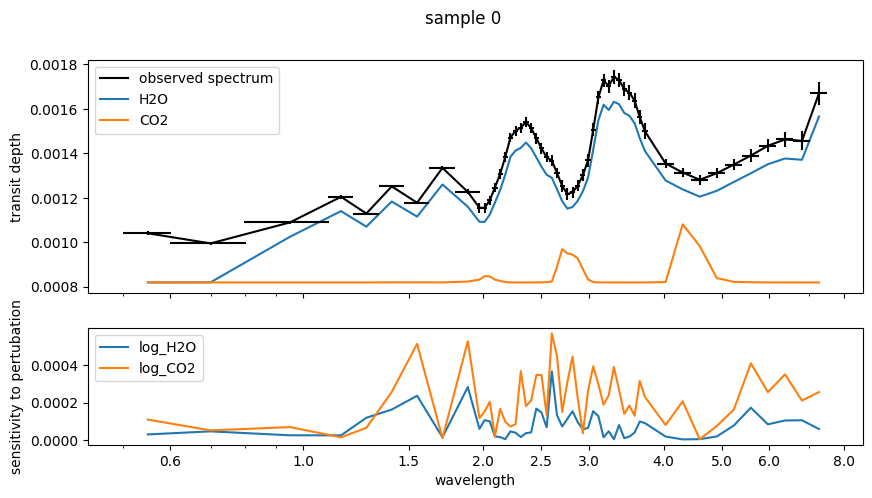

In [ ]:
i = 0
all_species = ds.species.values[1:]

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax_pert = ax[1]
ax = ax[0]

ax.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')


ax.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2',]
                    ).values.T, label=['H2O', 'CO2', ])


ax.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

# ax.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

ax_pert.plot(  ds['wavelength'] ,predictions_n[0, 0, :].std(axis=1), '-',label=label_names[0])
ax_pert.plot(  ds['wavelength'] ,predictions_n[0, 1, :].std(axis=1), '-',label=label_names[1])


ax_pert.set_xlabel('wavelength')
ax.set_ylabel('transit depth')
ax_pert.set_ylabel('sensitivity to pertubation')

ax.set_xscale('log')
ax.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

fig.suptitle(f'sample {i}')
ax_pert.legend(loc='upper left')
ax.legend()